<a href="https://www.kaggle.com/code/ganeshreddy045/notebook0e8648c3e5?scriptVersionId=285426489" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
import pandas as pd

path = "/kaggle/input/stocks-historical-price-data/historical_data"

dfs = []
for file in os.listdir(path):
    if file.endswith(".csv"):
        df = pd.read_csv(os.path.join(path, file))
        df["Ticker"] = file.replace(".csv", "")
        dfs.append(df)

data = pd.concat(dfs, ignore_index=True)
data["Date"] = pd.to_datetime(data["Date"])
data = data.sort_values(["Ticker", "Date"]).reset_index(drop=True)


In [2]:
apple = data[data["Ticker"] == "AAPL"].copy()
apple = apple.sort_values("Date").reset_index(drop=True)

apple.head()


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker
0,2019-05-31,43.181805,43.613062,42.877969,42.897572,108174400,0.0,0.0,AAPL
1,2019-06-03,43.027439,43.595909,41.721424,42.463867,161584400,0.0,0.0,AAPL
2,2019-06-04,42.988224,44.063910,42.762796,44.017353,123872000,0.0,0.0,AAPL
3,2019-06-05,45.154295,45.328268,44.384898,44.727940,119093600,0.0,0.0,AAPL
4,2019-06-06,44.860258,45.445882,44.632378,45.384624,90105200,0.0,0.0,AAPL


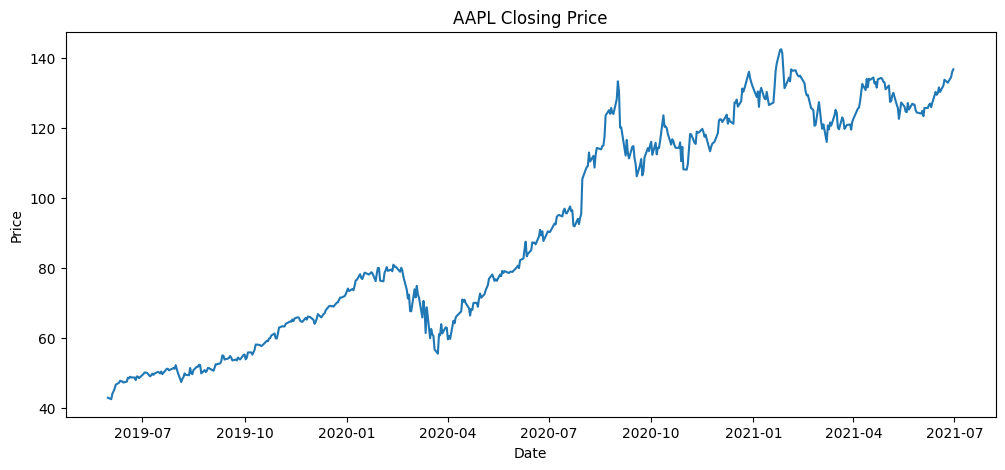

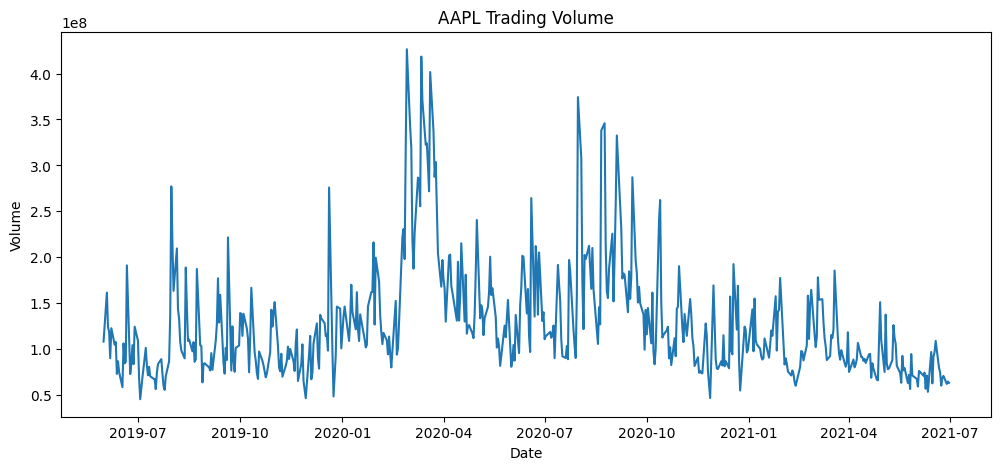

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,526,526.000000,526.000000,526.000000,526.000000,5.260000e+02,526.000000,526.000000
mean,2020-06-14 10:46:05.019011328,91.608297,92.723937,90.495177,91.658347,1.280820e+08,0.003075,0.007605
min,2019-05-31 00:00:00,42.988224,43.595909,41.721424,42.463867,4.544800e+07,0.000000,0.000000
25%,2019-12-05 06:00:00,63.748610,64.914196,63.372911,64.275314,8.736720e+07,0.000000,0.000000
50%,2020-06-15 12:00:00,86.864926,87.608795,85.528444,86.946747,1.112724e+08,0.000000,0.000000
75%,2020-12-20 06:00:00,122.473159,123.951533,120.681261,122.311106,1.507170e+08,0.000000,0.000000
max,2021-06-30 00:00:00,142.928469,144.411483,140.708887,142.490524,4.265100e+08,0.220000,4.000000
std,NaN,30.775590,31.076841,30.278098,30.670976,6.144065e+07,0.024792,0.174408


In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(apple["Date"], apple["Close"])
plt.title("AAPL Closing Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

plt.figure(figsize=(12,5))
plt.plot(apple["Date"], apple["Volume"])
plt.title("AAPL Trading Volume")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.show()

apple.describe()


In [4]:
# Ensure sorted by date
apple = apple.sort_values("Date").reset_index(drop=True)

# ---- Lag Features ----
for lag in [1, 5, 10]:
    apple[f"Close_lag_{lag}"] = apple["Close"].shift(lag)

# ---- Returns ----
apple["Return"] = apple["Close"].pct_change()

# ---- SMA & EMA ----
apple["SMA_10"] = apple["Close"].rolling(10).mean()
apple["EMA_10"] = apple["Close"].ewm(span=10).mean()

# ---- MACD ----
exp1 = apple["Close"].ewm(span=12).mean()
exp2 = apple["Close"].ewm(span=26).mean()
apple["MACD"] = exp1 - exp2

# ---- RSI ----
delta = apple["Close"].diff()
gain = delta.clip(lower=0)
loss = (-delta).clip(lower=0)
avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()
rs = avg_gain / avg_loss
apple["RSI"] = 100 - (100 / (1 + rs))

# Drop NaN rows created during indicator calc
apple = apple.dropna().reset_index(drop=True)


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


In [5]:
drop_cols = ["Date", "Ticker"]

features = apple.drop(columns=["Close"] + drop_cols)
target = apple["Close"]

split = int(len(apple) * 0.8)

train_features = features.iloc[:split]
train_target   = target.iloc[:split]

test_features  = features.iloc[split:]
test_target    = target.iloc[split:]
test_dates     = apple["Date"].iloc[split:]


In [6]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=8,
    random_state=42
)
rf.fit(train_features, train_target)

pred_rf = rf.predict(test_features)


import xgboost as xgb

xgb_model = xgb.XGBRegressor(
    n_estimators=400,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(train_features, train_target)

pred_xgb = xgb_model.predict(test_features)


In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

print("RF RMSE:", np.sqrt(mean_squared_error(test_target, pred_rf)))
print("XGB RMSE:", np.sqrt(mean_squared_error(test_target, pred_xgb)))
print("RF MAE:", mean_absolute_error(test_target, pred_rf))
print("XGB MAE:", mean_absolute_error(test_target, pred_xgb))


RF RMSE: 1.1836748384905398
XGB RMSE: 1.0391782543559578
RF MAE: 0.9426066159305092
XGB MAE: 0.8586317636434313


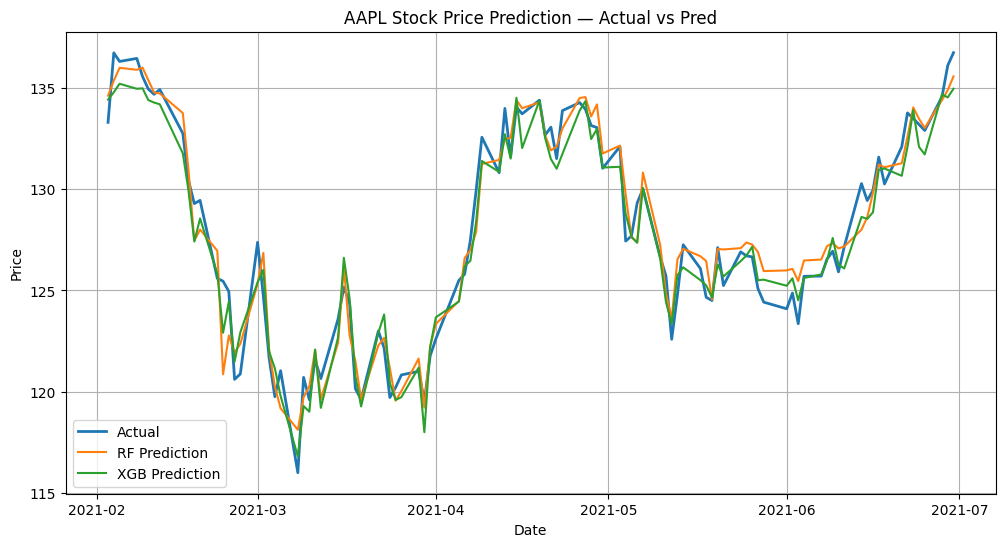

In [8]:
plt.figure(figsize=(12,6))
plt.plot(test_dates, test_target, label="Actual", linewidth=2)
plt.plot(test_dates, pred_rf, label="RF Prediction")
plt.plot(test_dates, pred_xgb, label="XGB Prediction")
plt.title("AAPL Stock Price Prediction — Actual vs Pred")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()
